In [2]:
!pip install -q -r requirements.txt

In [1]:
import subprocess
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from scipy import stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import warnings
from wordcloud import WordCloud


pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('default')


for resource in ['vader_lexicon', 'stopwords', 'wordnet', 'punkt']:
    nltk.download(resource, quiet=True)

In [ ]:
path = '/dataset/corpus-webis-tldr-17.json'

df = pd.read_json(path, lines=True, nrows=300000)
print(f"Dataset dims: {df.shape[0]:,} row, {df.shape[1]} col")
print(f"Non-null count: {df['content'].notna().sum():,}")

Dataset dims: 300,000 row, 11 col
Non-null count: 300,000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   author          300000 non-null  object
 1   body            300000 non-null  object
 2   normalizedBody  300000 non-null  object
 3   content         300000 non-null  object
 4   content_len     300000 non-null  int64 
 5   summary         300000 non-null  object
 6   summary_len     300000 non-null  int64 
 7   id              300000 non-null  object
 8   subreddit       300000 non-null  object
 9   subreddit_id    300000 non-null  object
 10  title           14936 non-null   object
dtypes: int64(2), object(9)
memory usage: 25.2+ MB

Subreddit Value Counts:
subreddit
AskReddit            70570
leagueoflegends       7360
AdviceAnimals         5709
funny                 5235
gaming                4721
politics              4690
pics                  4570
atheism               4155
to

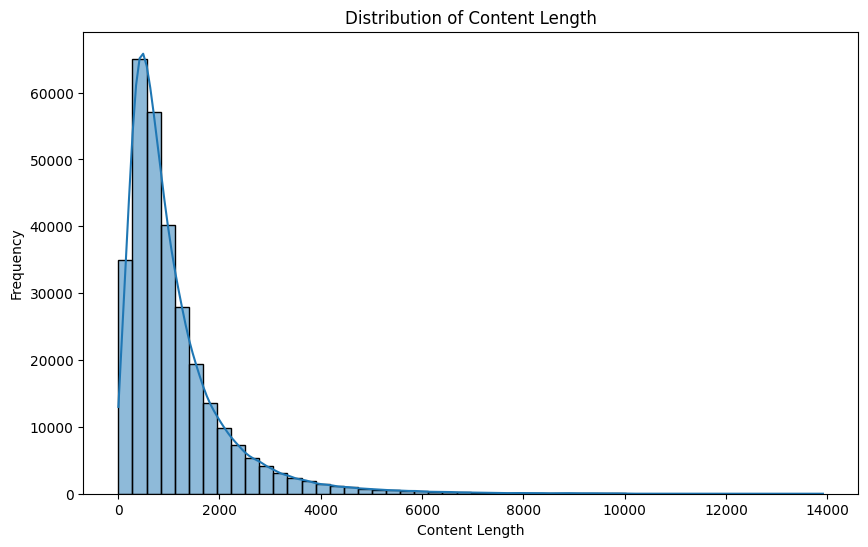

In [3]:
df.info()

df.describe()


if 'subreddit' in df.columns:
    print("\nSubreddit Value Counts:")
    print(df['subreddit'].value_counts().head(10)) # Display top 10 subreddits


df['content_length'] = df['content'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'].dropna(), bins=50, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
with open('subreddits.txt', 'r') as f:
  political_subreddits = [line.strip().lower() for line in f]
  df_political = df[df['subreddit'].str.lower().isin(political_subreddits)].copy()
df_political.head(7)

,author,body,normalizedBody,content,content_len,summary,summary_len,id,subreddit,subreddit_id,title,content_length
54,SpermJackalope,"Fuck that noise. Yes, sorority girls dress sim...","Fuck that noise. Yes, sorority girls dress sim...","Fuck that noise. Yes, sorority girls dress sim...",182,"Yes, you're totally right to feel something is...",12,c6ec4y7,SRSDiscussion,t5_2t5sa,NaN,1086
119,argv_minus_one,If your opponent's policies are bad for the co...,If your opponent's policies are bad for the co...,If your opponent's policies are bad for the co...,94,Republicans are traitors to the United States.,7,c6ku714,politics,t5_2cneq,NaN,546
160,adjecentautophobe,&gt;Please point me to which provision removed...,>Please point me to which provision removed re...,Please point me to which provision removed reg...,971,You dont seem to know what a credit default sw...,66,c6opxxp,politics,t5_2cneq,NaN,5760
200,DejaBoo,Just came from a 3 week visit there. A good r...,Just came from a 3 week visit there. A good r...,Just came from a 3 week visit there. A good r...,466,To SA Blacks Freedom is not the same thing to ...,31,c6svhc9,worldevents,t5_2riv9,NaN,2628
206,thetasigma1355,Highly educated Americans were sold the belief...,Highly educated Americans were sold the belief...,Highly educated Americans were sold the belief...,101,"It was a scam that targeted ""highly educated"" ...",21,c6thkch,TrueReddit,t5_2qyt6,NaN,567
218,mauxly,I'm so confused. I really am. On one hand I th...,I'm so confused. I really am. On one hand I th...,I'm so confused. I really am. On one hand I th...,130,Circular ramblings of an incoherent mind. Yay ...,14,c6upphz,politics,t5_2cneq,NaN,675
262,Aumah,The GOP lost this - not Romney. Romney did eve...,The GOP lost this - not Romney. Romney did eve...,The GOP lost this - not Romney. Romney did eve...,90,Romney a pro race car driver asked to drive ar...,17,c6xpu9i,Conservative,t5_2qh6p,NaN,563


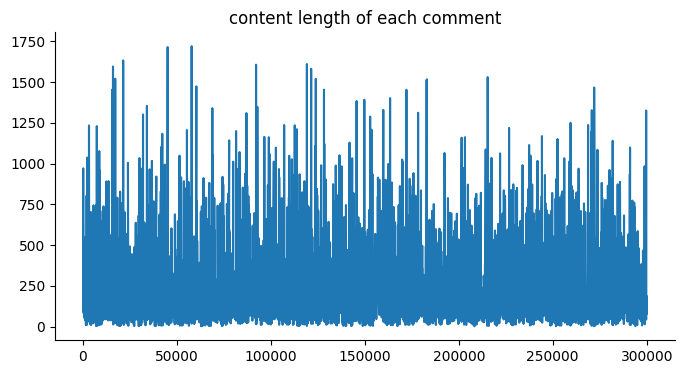

In [5]:
df_political['content_len'].plot(kind='line', figsize=(8, 4), title='content length of each comment')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words.update(['would', 'could', 'should', 'like', 'get', 'go', 'know', 'think', 'make', 'actually', 'say', 'want', 'thing'])

    def clean_text(self, text):
        if not isinstance(text, str) or not text.strip():
            return ''
        text = text.lower()
        text = re.sub(r'http[s]?://\S+', '', text)  #remove URLs
        text = re.sub(r'/[ur]/\w+', '', text)  #remove Reddit mentions
        text = re.sub(r'[^\w\s]', ' ', text)  #remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  #clean whitespace

        words = [self.lemmatizer.lemmatize(word) for word in text.split()
                if word not in self.stop_words and len(word) > 2 and word.isalpha()]
        return ' '.join(words)

def preprocess_data(df_political):
    preprocessor = TextPreprocessor()
    df_political['cleaned_content'] = df_political['content'].apply(preprocessor.clean_text)

    #removing empty texts
    df_political = df_political[df_political['cleaned_content'].str.len() > 0].copy()

    print(f"preprocessed result: {len(df_political):,} valid texts")
    return df_political

df_political = preprocess_data(df_political)


preprocessed result: 8,781 valid texts


In [7]:
class TopicAnalyzer:
    def __init__(self):
        self.vectorizer = None
        self.tfidf_matrix = None
        self.best_model = None
        self.best_n_topics = None

    def calculate_coherence(self, model, n_topics):
        feature_names = self.vectorizer.get_feature_names_out()
        coherence_scores = []
        for topic_idx in range(n_topics):
            # Get top 10 words for topic
            top_indices = model.components_[topic_idx].argsort()[-10:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            #Calculate pairwise PMI
            coherence = 0
            pairs = 0
            for i in range(len(top_words)):
                for j in range(i+1, len(top_words)):
                    word1, word2 = top_words[i], top_words[j]
                    idx1 = np.where(feature_names == word1)[0]
                    idx2 = np.where(feature_names == word2)[0]
                    if len(idx1) > 0 and len(idx2) > 0:
                        distance = abs(idx1[0] - idx2[0])
                        coherence += 1.0 / (1.0 + distance / 100.0)
                        pairs += 1
            if pairs > 0:
                coherence_scores.append(coherence / pairs)
            else:
                coherence_scores.append(0)
        return np.mean(coherence_scores)

    def find_optimal_topics(self, texts, topic_range=(3, 8)):
        print("Finding optimal number of topics...")
        #tfidf vectorizer
        self.vectorizer = TfidfVectorizer(
            max_features=1500,
            min_df=3,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english',
        )

        self.tfidf_matrix = self.vectorizer.fit_transform(texts)

        coherence_scores = []
        perplexity_scores = []
        topic_numbers = list(range(topic_range[0], topic_range[1] + 1))

        for n_topics in topic_numbers:
            # NMF for coherence
            nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=100)
            nmf_model.fit(self.tfidf_matrix)

            coherence = self.calculate_coherence(nmf_model, n_topics)
            coherence_scores.append(coherence)

            # LDA for perplexity
            lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=50)
            lda_model.fit(self.tfidf_matrix)
            perplexity = lda_model.perplexity(self.tfidf_matrix)
            perplexity_scores.append(perplexity)

            print(f"  {n_topics} topics: coherence={coherence:.4f}, perplexity={perplexity:.2f}")

        # Select optimal based on coherence
        optimal_idx = np.argmax(coherence_scores)
        self.best_n_topics = topic_numbers[optimal_idx]

        print(f"\nOptimal topics: {self.best_n_topics}")
        return topic_numbers, coherence_scores, perplexity_scores

    def fit_final_model(self):
        self.best_model = NMF(
            n_components=self.best_n_topics,
            random_state=42,
            max_iter=200
        )
        topic_weights = self.best_model.fit_transform(self.tfidf_matrix)
        return topic_weights.argmax(axis=1)

    def get_topics(self, n_words=10):
        feature_names = self.vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(self.best_model.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-n_words:][::-1]]
            topics[f"Topic {topic_idx}"] = top_words
        return topics

def perform_topic_modeling(df_political):
    # Filter texts for topic modeling
    valid_texts = df_political[df_political['cleaned_content'].str.len() > 50]['cleaned_content']
    print(f"Texts for topic modeling: {len(valid_texts):,}")

    analyzer = TopicAnalyzer()

    #Find optimal no of topics
    topic_numbers, coherence_scores, perplexity_scores = analyzer.find_optimal_topics(valid_texts)

    #Fit model
    topic_assignments = analyzer.fit_final_model()

    #Get topic interpretations
    topics = analyzer.get_topics()

    #Assign topics to dataframe
    df_political['dominant_topic'] = -1
    valid_indices = df_political[df_political['cleaned_content'].str.len() > 50].index
    if len(topic_assignments) == len(valid_indices):
        df_political.loc[valid_indices, 'dominant_topic'] = topic_assignments

    print("\nTopic interpretation:")
    for topic_name, words in topics.items():
        print(f"{topic_name}: {', '.join(words[:6])}")

    return df_political, topics

df_political, topics = perform_topic_modeling(df_political)


Texts for topic modeling: 8,603
Finding optimal number of topics...
  3 topics: coherence=0.2635, perplexity=1703.43
  4 topics: coherence=0.2599, perplexity=1922.98
  5 topics: coherence=0.2544, perplexity=2105.47


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


  6 topics: coherence=0.2537, perplexity=2254.69
  7 topics: coherence=0.2625, perplexity=2432.84
  8 topics: coherence=0.2648, perplexity=2542.34

Optimal topics: 8

Topic interpretation:
Topic 0: people, way, time, point, really, woman
Topic 1: government, money, company, market, bank, cost
Topic 2: party, vote, republican, democrat, obama, election
Topic 3: state, law, government, right, court, united
Topic 4: tax, income, pay, rate, income tax, tax rate
Topic 5: school, student, education, year, college, kid
Topic 6: gun, firearm, crime, weapon, violence, shooting
Topic 7: job, wage, work, minimum, worker, minimum wage


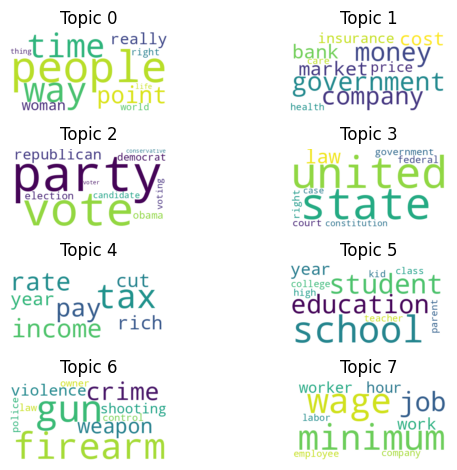

In [8]:
for i, (topic_name, words) in enumerate(topics.items()):
    text = ' '.join(words[:20])
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    plt.subplot(4, 2, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(topic_name)

plt.tight_layout()
plt.show()

In [9]:
def classify_political_data(df):
    political_cat = {
    '2012Elections': 'Election',
    '2016Elections': 'Election',
    '2016_elections': 'Election',
    '2ALiberals': 'Left',
    'AOC': 'Election',
    'Abortiondebate': 'Center',
    'ActiveMeasures': 'Geopolitics',
    'AgainstHateSubreddits': 'Left',
    'AgainstTheChimpire': 'Left',
    'Agorism': 'Right',
    'Albertapolitics': 'Geopolitics',
    'AlexandriaOcasio': 'Election',
    'AltRightChristian': 'Right',
    'AmalaNetwork': 'Job and Finance',
    'AmericanPolitics': 'Left',
    'AnCap101': 'Right',
    'Anarchism': 'Left',
    'AnarchismOnline': 'Left',
    'AnarchistNews': 'Left',
    'Anarcho_Capitalism': 'Right',
    'Anarchy101': 'Left',
    'AntiSemitismInReddit': 'Left',
    'AntiTrumpAlliance': 'Election',
    'AnticommieCringe': 'Right',
    'AntifascistsofReddit': 'Left',
    'AnybodyButHillary': 'Election',
    'AnythingGoesNews': 'Other',
    'AprogressiveParty': 'Left',
    'ArabIsraeliConflict': 'Geopolitics',
    'ArrestedCanadaBillC16': 'Law and Crime',
    'AsAGunOwner': 'Right',
    'AskALiberal': 'Left',
    'AskBernieSupporters': 'Election',
    'AskConservatives': 'Right',
    'AskDemocrats': 'Election',
    'AskEconomics': 'Job and Finance',
    'AskFeminists': 'Left',
    'AskFemmeThoughts': 'Left',
    'AskLibertarians': 'Right',
    'AskSocialScience': 'Other',
    'AskThe_Donald': 'Election',
    'AskTrumpSupporters': 'Election',
    'Ask_Politics': 'Left',
    'Ask_TheDonald': 'Election',
    'Askpolitics': 'Left',
    'AusPol': 'Geopolitics',
    'AustraliaLeftPolitics': 'Geopolitics',
    'AustralianPolitics': 'Geopolitics',
    'AutoNewspaper': 'Other',
    'BCpolitics': 'Geopolitics',
    'BDS': 'Geopolitics',
    'BadSocialScience': 'Other',
    'BannedFromThe_Donald': 'Election',
    'BasicIncome': 'Job and Finance',
    'BeardTube': 'Other',
    'BerlinTruckAttack': 'Law and Crime',
    'BernieSanders': 'Election',
    'BernieSandersSucks': 'Election',
    'Beto2020': 'Election',
    'BitcoinDiscussion': 'Job and Finance',
    'BlueMidterm2018': 'Election',
    'BreakingNews24hr': 'Other',
    'BritishPolitics': 'Geopolitics',
    'CAVDEF': 'Other',
    'CNNmemes': 'Job and Finance',
    'COMPLETEANARCHY': 'Left',
    'California_Politics': 'Geopolitics',
    'CanadaPolitics': 'Geopolitics',
    'CanadianPolitics': 'Geopolitics',
    'Capitalism': 'Right',
    'CapitalismVSocialism': 'Left',
    'Cascadia': 'Geopolitics',
    'CatholicPolitics': 'Right',
    'China_Debate': 'Geopolitics',
    'Classical_Liberals': 'Right',
    'ColoradoPolitics': 'Geopolitics',
    'Communalists': 'Left',
    'CommunismWorldwide': 'Left',
    'Conservative': 'Right',
    'ConservativeLounge': 'Right',
    'ConservativeMeta': 'Right',
    'ConservativeNewsWeb': 'Right',
    'ConservativesOnly': 'Right',
    'Conservatives_R_Us': 'Right',
    'DNCleaks': 'Election',
    'DankLeft': 'Left',
    'DarkEnlightenment': 'Right',
    'Dave_Rubin': 'Other',
    'DeathtoAmeriKKKa': 'Left',
    'DebateAltRight': 'Right',
    'DebateAnarchism': 'Left',
    'DebateCommunism': 'Left',
    'DebateFascism': 'Right',
    'DebateaCommunist': 'Left',
    'DemocraticSocialism': 'Left',
    'Democrats2020': 'Election',
    'DescentIntoTyranny': 'Left',
    'Digital_Manipulation': 'Job and Finance',
    'DitchMitch': 'Election',
    'DonaldTrumpWhiteHouse': 'Election',
    'Donald_Trump': 'Election',
    'DrainTheSwamp': 'Election',
    'Drumpf': 'Election',
    'ENLIGHTENEDCENTRISM': 'Left',
    'EarthStrike': 'Other',
    'EcoInternet': 'Other',
    'Economics': 'Job and Finance',
    'EducatingLiberals': 'Right',
    'Egalitarianism': 'Left',
    'ElizabethWarren': 'Election',
    'EmergingRisks': 'Other',
    'EndFPTP': 'Left',
    'EndlessWar': 'Geopolitics',
    'EnoughCapitalistSpam': 'Left',
    'EnoughCommieSpam': 'Right',
    'EnoughIDWspam': 'Left',
    'EnoughLibertarianSpam': 'Left',
    'EnoughObamaSpam': 'Election',
    'EnoughPaulSpam': 'Election',
    'EnoughTrumpSpam': 'Election',
    'Enough_AOC_Spam': 'Election',
    'Enough_Sanders_Spam': 'Election',
    'EuropeMeta': 'Geopolitics',
    'EuropeanFederalists': 'Geopolitics',
    'EuropeanSocialists': 'Geopolitics',
    'ExplainBothSides': 'Other',
    'FLgovernment': 'Geopolitics',
    'FULLCOMMUNISM': 'Left',
    'FULLDISCOURSE': 'Left',
    'FakeProgressives': 'Left',
    'FeMRADebates': 'Left',
    'FemraMeta': 'Left',
    'FoxFiction': 'Job and Finance',
    'Foxhidesinfo': 'Job and Finance',
    'FreeEuropeNews': 'Other',
    'FreePolDiscussion': 'Left',
    'FreeSpeech': 'Right',
    'FreeSpeechWorld': 'Right',
    'Freethought': 'Left',
    'FriendsofthePod': 'Other',
    'Fuckthealtright': 'Left',
    'Full_news': 'Other',
    'GAPol': 'Geopolitics',
    'GBPolitics': 'Geopolitics',
    'GUARDIANauto': 'Other',
    'GaryJohnson': 'Election',
    'GenZedong': 'Left',
    'GeneralStrikeUSA': 'Job and Finance',
    'GoldandBlack': 'Right',
    'Government_is_lame': 'Right',
    'GrassrootsSelect': 'Election',
    'GreenAndPleasant': 'Left',
    'GreenNewDeal': 'Left',
    'GreenParty': 'Election',
    'GunsAreCool': 'Left',
    'HBDstats': 'Other',
    'HanAssholeSolo': 'Other',
    'HateSubsInAction': 'Left',
    'HeadlineCorrections': 'Other',
    'Hillary': 'Election',
    'HillaryForAmerica': 'Election',
    'HillaryForPrison': 'Election',
    'HongKongProtest': 'Geopolitics',
    'IAMALiberalFeminist': 'Left',
    'IDontLikeRPolitics': 'Left',
    'IWG': 'Other',
    'IWW': 'Job and Finance',
    'Identitarians': 'Right',
    'ImABlue': 'Election',
    'Impeach_Trump': 'Election',
    'ImpeachmentWatch': 'Election',
    'IndoPakDialogue': 'Geopolitics',
    'IntellectualDarkWeb': 'Other',
    'Intelligence': 'Other',
    'IntelligenceNews': 'Other',
    'InternationalNews': 'Geopolitics',
    'IronFrontUSA': 'Left',
    'IslamUnveiled': 'Right',
    'Israel': 'Geopolitics',
    'IsraelPalestine': 'Geopolitics',
    'IsraelSubredditWatch': 'Geopolitics',
    'Israel_Palestine': 'Geopolitics',
    'JamesDamore': 'Other',
    'JoeBiden': 'Election',
    'JordanPeterson': 'Other',
    'Jreg': 'Other',
    'Kamala': 'Election',
    'KasichForPresident': 'Election',
    'KeepOurNetFree': 'Left',
    'Keep_Track': 'Left',
    'KochWatch': 'Job and Finance',
    'Kossacks_for_Sanders': 'Election',
    'Labour': 'Left',
    'LabourUK': 'Left',
    'LateStageCommunism': 'Left',
    'LateStageImperialism': 'Left',
    'LateStageSocialism': 'Left',
    'Le_Pen': 'Election',
    'LeftWingMaleAdvocates': 'Left',
    'LeftWithoutEdge': 'Left',
    'LeftieZ': 'Left',
    'LeftistHotTakes': 'Left',
    'Lessig2016': 'Election',
    'LevantineWar': 'Geopolitics',
    'LibDem': 'Left',
    'Liberal': 'Left',
    'Liberalist': 'Right',
    'LiberalsvsNazis': 'Left',
    'Libertarian': 'Right',
    'LibertarianDebates': 'Right',
    'LibertarianFreeState': 'Right',
    'LibertarianLeft': 'Left',
    'LibertarianPartyUSA': 'Right',
    'LibertarianUncensored': 'Right',
    'LouderWithCrowder': 'Other',
    'MENAConflicts': 'Geopolitics',
    'MarchAgainstNazis': 'Left',
    'MarchAgainstTrump': 'Election',
    'MarchForNetNeutrality': 'Left',
    'MarchForScience': 'Other',
    'Marco_Rubio': 'Election',
    'MarketAnarchism': 'Right',
    'Marxism': 'Left',
    'MassachusettsPolitics': 'Geopolitics',
    'MedicareForAll': 'Left',
    'MensRightsMeta': 'Right',
    'MetaRepublican': 'Right',
    'MideastPeace': 'Geopolitics',
    'MissouriPolitics': 'Geopolitics',
    'MobilizedMinds': 'Left',
    'ModernPropaganda': 'Job and Finance',
    'MoreTankieChapo': 'Left',
    'Mueller': 'Election',
    'MurderedByAOC': 'Election',
    'NATOrussianconflict': 'Geopolitics',
    'NOWTTYG': 'Other',
    'NSALeaks': 'Other',
    'NationalSocialism': 'Right',
    'NegaRedditRedux': 'Other',
    'NeutralPolitics': 'Center',
    'NeutralTalk': 'Center',
    'NeverTrump': 'Election',
    'NewJerseyuncensored': 'Geopolitics',
    'NewPatriotism': 'Left',
    'New_Jersey_Politics': 'Geopolitics',
    'NewsWhatever': 'Other',
    'Newsy': 'Other',
    'NoFilterNews': 'Other',
    'NoNetNeutrality': 'Right',
    'NonAustrianEconomics': 'Job and Finance',
    'NorthKoreaNews': 'Geopolitics',
    'Objectivism': 'Right',
    'Occupy': 'Left',
    'OntarioPolitics': 'Geopolitics',
    'OperationPullRyan': 'Election',
    'Oregon_Politics': 'Geopolitics',
    'OurPresident': 'Election',
    'Our_Politics': 'Left',
    'POLITIC': 'Left',
    'POTUSWatch': 'Election',
    'Palestine': 'Geopolitics',
    'PalestineCircleJerk': 'Geopolitics',
    'PalestineIntifada': 'Geopolitics',
    'PanicHistory': 'Other',
    'PeoplesPartyofCanada': 'Election',
    'Pete_Buttigieg': 'Election',
    'Physical_Removal': 'Right',
    'Polcompball': 'Left',
    'Policy2011': 'Left',
    'PoliticalCompass': 'Left',
    'PoliticalCompassMemes': 'Left',
    'PoliticalDiscussion': 'Left',
    'PoliticalHorrorStory': 'Left',
    'PoliticalHumor': 'Left',
    'PoliticalHumour': 'Left',
    'PoliticalMemes': 'Left',
    'PoliticalOpinions': 'Left',
    'PoliticalPhilosophy': 'Left',
    'PoliticalVideo': 'Left',
    'Political_Revolution': 'Left',
    'Political_Tumor': 'Left',
    'Political_Tweets': 'Left',
    'Postleftanarchism': 'Left',
    'PragerUrine': 'Job and Finance',
    'Pragmatism': 'Left',
    'PraxAcceptance': 'Right',
    'PresidentWarren': 'Election',
    'PresidentialRaceMemes': 'Election',
    'PublicLands': 'Other',
    'Pyongyang': 'Geopolitics',
    'QualitySocialism': 'Left',
    'RedEnsign': 'Right',
    'ReddLineNews': 'Other',
    'RedditCensors': 'Other',
    'RedsKilledTrillions': 'Right',
    'Reform_The_DNC': 'Election',
    'Republican': 'Right',
    'RepublicanValues': 'Right',
    'RepublicansForSanders': 'Election',
    'Right_Wing_Politics': 'Right',
    'RightwingLGBT': 'Right',
    'RiseUPP': 'Left',
    'Romney': 'Election',
    'RsocialismMeta': 'Left',
    'RussiaLago': 'Geopolitics',
    'SRSDiscussion': 'Other',
    'SandersForPresident': 'Election',
    'SargonofAkkad': 'Other',
    'SelfAwarewolves': 'Left',
    'SethRich': 'Law and Crime',
    'ShitLiberalsSay': 'Left',
    'ShitNeoconsSay': 'Left',
    'ShitPoliticsSays': 'Right',
    'ShitPoppinKreamSays': 'Other',
    'ShitRConservativeSays': 'Left',
    'ShitThe_DonaldSays': 'Left',
    'Shitstatistssay': 'Right',
    'ShittyDebateCommunism': 'Left',
    'Sino': 'Geopolitics',
    'SmugIdeologyMan': 'Left',
    'SocialDemocracy': 'Left',
    'SocialismVCapitalism': 'Left',
    'Socialism_101': 'Left',
    'Sorosforprison': 'Other',
    'SpeechFree': 'Right',
    'StillSandersForPres': 'Election',
    'StormfrontorSJW': 'Left',
    'SyndiesUnited': 'Left',
    'SyrianRebels': 'Geopolitics',
    'TYT': 'Job and Finance',
    'TedCruzForPresident': 'Election',
    'TennesseePolitics': 'Geopolitics',
    'TexasPolitics': 'Geopolitics',
    'ThanksObama': 'Election',
    'The3rdPosition': 'Right',
    'TheColorIsBlue': 'Election',
    'TheColorIsRed': 'Election',
    'TheLeftCantMeme': 'Right',
    'TheMajorityReport': 'Job and Finance',
    'TheMotte': 'Other',
    'TheNewRight': 'Right',
    'TheNewsFeed': 'Other',
    'TheRecordCorrected': 'Left',
    'The_Cabal': 'Other',
    'The_Congress': 'Right',
    'The_Donald': 'Election',
    'The_Donald_CA': 'Election',
    'The_Europe': 'Geopolitics',
    'The_Farage': 'Election',
    'The_Leftorium': 'Left',
    'The_Mueller': 'Election',
    'The_MuellerMeltdown': 'Election',
    'ThisButUnironically': 'Left',
    'ThreeArrows': 'Left',
    'TiADiscussion': 'Other',
    'TimCanova': 'Election',
    'TommyRobinson': 'Other',
    'TraaButNoCommies': 'Right',
    'TrueCatholicPolitics': 'Right',
    'TruePoliticalHumor': 'Right',
    'TrueReddit': 'Other',
    'TrueTrueReddit': 'Other',
    'True_AskAConservative': 'Right',
    'TrumpCriticizesTrump': 'Election',
    'TrumpForPrison': 'Election',
    'Trump_Watch': 'Election',
    'Trumpgret': 'Election',
    'Trumpgrets': 'Election',
    'UK_Politics': 'Geopolitics',
    'UMukhasimAutoNews': 'Other',
    'USNEWS': 'Other',
    'UkrainianConflict': 'Geopolitics',
    'Ultraleft': 'Left',
    'UnbiasedCanada': 'Geopolitics',
    'VaushVidya': 'Other',
    'VirginiaPolitics': 'Geopolitics',
    'VoteBlue': 'Election',
    'Vote_Trump': 'Election',
    'WatchRedditDie': 'Other',
    'WayOfTheAloha': 'Other',
    'WayOfTheBern': 'Election',
    'WhatsMyIdeology': 'Left',
    'WhereAreTheChildren': 'Other',
    'WhereIsAssange': 'Other',
    'WhiteRights': 'Right',
    'WikiInAction': 'Other',
    'WikiLeaks': 'Other',
    'YangForPresident': 'Election',
    'YangForPresidentHQ': 'Election',
    'YangGang': 'Election',
    'YemeniCrisis': 'Geopolitics',
    'Zionism': 'Right',
    'abetterworldnews': 'Other',
    'accidentallycommunist': 'Left',
    'acteuropa': 'Geopolitics',
    'actualconspiracies': 'Other',
    'actualliberalgunowner': 'Left',
    'agitation': 'Left',
    'alltheleft': 'Left',
    'altnewz': 'Other',
    'altright': 'Right',
    'anarcho_primitivism': 'Left',
    'anarchocommunism': 'Left',
    'anarchomemes': 'Left',
    'anarchy': 'Left',
    'antifa': 'Left',
    'antifapassdenied': 'Right',
    'antiwar': 'Geopolitics',
    'arizonapolitics': 'Geopolitics',
    'askaconservative': 'Right',
    'askhillarysupporters': 'Election',
    'atheismplus': 'Other',
    'austrian_economics': 'Job and Finance',
    'badeconomics': 'Job and Finance',
    'badgovnofreedom': 'Right',
    'badpolitics': 'Left',
    'benshapiro': 'Other',
    'bernie': 'Election',
    'bernieblindness': 'Election',
    'besteurope': 'Geopolitics',
    'betternews': 'Other',
    'brealism': 'Left',
    'brexit': 'Geopolitics',
    'calexit': 'Geopolitics',
    'canadaleft': 'Geopolitics',
    'capitalism_in_decay': 'Left',
    'censorship': 'Right',
    'centerleftpolitics': 'Left',
    'centrist': 'Center',
    'chinareddits': 'Geopolitics',
    'chomsky': 'Left',
    'climateskeptics': 'Other',
    'communism': 'Left',
    'communism101': 'Left',
    'communists': 'Left',
    'conservativecartoons': 'Right',
    'conservatives': 'Right',
    'conspiracyfact': 'Other',
    'conspiratocracy': 'Other',
    'craftofintelligence': 'Other',
    'cyberlaws': 'Law and Crime',
    'daverubin': 'Other',
    'debateAMR': 'Left',
    'debatepoliticalphil': 'Left',
    'democraticparty': 'Election',
    'democrats': 'Election',
    'demsocialist': 'Left',
    'demsocialists': 'Left',
    'dirtbagcenter': 'Center',
    'distributism': 'Right',
    'donaldtrump': 'Election',
    'dsa': 'Left',
    'econmonitor': 'Job and Finance',
    'economy': 'Job and Finance',
    'enoughpetersonspam': 'Other',
    'enoughsandersspam': 'Election',
    'esist': 'Left',
    'europeannationalism': 'Geopolitics',
    'europeans': 'Geopolitics',
    'europeanunion': 'Geopolitics',
    'europes': 'Geopolitics',
    'evolutionReddit': 'Other',
    'exlibertarian': 'Left',
    'fascist': 'Right',
    'feminismformen': 'Left',
    'fivethirtyeight': 'Other',
    'foreignpolicy': 'Geopolitics',
    'fullstalinism': 'Left',
    'futuristparty': 'Left',
    'geopolitics': 'Geopolitics',
    'georgism': 'Left',
    'globalistshills': 'Left',
    'googoogahgah': 'Other',
    'government': 'Left',
    'gravelforpresident': 'Election',
    'greed': 'Other',
    'gue': 'Other',
    'gulag': 'Law and Crime',
    'guncontrol': 'Left',
    'gunpolitics': 'Right',
    'hillaryclinton': 'Election',
    'historicalrage': 'Other',
    'holocaust': 'Other',
    'illinoispolitics': 'Geopolitics',
    'indianmuslims': 'Geopolitics',
    'inslee2020': 'Election',
    'inthemorning': 'Other',
    'inthenews': 'Other',
    'iranpolitics': 'Geopolitics',
    'irishpolitics': 'Geopolitics',
    'irredeemables': 'Left',
    'israelexposed': 'Geopolitics',
    'jillstein': 'Election',
    'jimmydore': 'Other',
    'justicedemocrats': 'Left',
    'killthosewhodisagree': 'Left',
    'labor': 'Job and Finance',
    'law': 'Law and Crime',
    'leftcommunism': 'Left',
    'liberalgunowners': 'Left',
    'libertarianaustralia': 'Right',
    'libertarianmeme': 'Right',
    'libtard': 'Right',
    'marxism_101': 'Left',
    'media_criticism': 'Job and Finance',
    'metaNL': 'Other',
    'metanarchism': 'Left',
    'militant': 'Left',
    'mmt_economics': 'Job and Finance',
    'moderatepolitics': 'Center',
    'monarchism': 'Right',
    'mormonpolitics': 'Right',
    'mutualism': 'Left',
    'ndp': 'Left',
    'neoconNWO': 'Right',
    'neoliberal': 'Right',
    'neoprogs': 'Left',
    'neutralnews': 'Other',
    'nevadapolitics': 'Geopolitics',
    'neveragainmovement': 'Left',
    'new_right': 'Right',
    'nonmorons': 'Other',
    'nra': 'Right',
    'nrxn': 'Right',
    'nyspolitics': 'Geopolitics',
    'obama': 'Election',
    'obamacare': 'Left',
    'occupywallstreet': 'Left',
    'onguardforthee': 'Geopolitics',
    'overpopulation': 'Other',
    'pol': 'Left',
    'politicalcartoons': 'Left',
    'politicalfactchecking': 'Left',
    'politicalhinduism': 'Right',
    'politics': 'Left',
    'politicsdebate': 'Left',
    'postnationalist': 'Left',
    'prochoice': 'Left',
    'progressive': 'Left',
    'progun': 'Right',
    'prolife': 'Right',
    'propaganda': 'Job and Finance',
    'qualitynews': 'Other',
    'race': 'Other',
    'randpaul': 'Election',
    'realworldpolitics': 'Left',
    'redacted': 'Left',
    'republicans': 'Right',
    'restorethefourth': 'Left',
    'revolution': 'Left',
    'rojava': 'Geopolitics',
    'ronpaul': 'Election',
    'samharris': 'Other',
    'scotus': 'Law and Crime',
    'secondamendment': 'Law and Crime',
    'seculartalk': 'Other',
    'shitfascistssay': 'Left',
    'shitguncontrollerssay': 'Right',
    'shitleftistssay': 'Right',
    'shitneoliberalismsays': 'Left',
    'shittankiessay': 'Left',
    'slatestarcodex': 'Other',
    'slatestarcodex_cw': 'Other',
    'smuggies': 'Right',
    'socialanarchism': 'Left',
    'socialism': 'Left',
    'socialjustice101': 'Left',
    'stevencrowder': 'Other',
    'stopadvertising': 'Other',
    'stupidpol': 'Left',
    'syriancivilwar': 'Geopolitics',
    'syrianconflict': 'Geopolitics',
    'taxmarch': 'Job and Finance',
    'terrorism': 'Law and Crime',
    'the_meltdown': 'Election',
    'thedavidpakmanshow': 'Other',
    'thenewcoldwar': 'Geopolitics',
    'thenewsrightnow': 'Other',
    'theredpillright': 'Right',
    'thomasjefferson': 'Other',
    'tories': 'Right',
    'trollfare': 'Other',
    'trump': 'Election',
    'trump16': 'Election',
    'trumptweets': 'Election',
    'tuesday': 'Center',
    'tulsi': 'Election',
    'tytonreddit': 'Other',
    'ukipparty': 'Right',
    'ukpolitics': 'Geopolitics',
    'ukright': 'Right',
    'uncensorednews': 'Other',
    'unfilter': 'Other',
    'union': 'Job and Finance',
    'usanews': 'Other',
    'uspolitics': 'Geopolitics',
    'venezuelancivilwar': 'Geopolitics',
    'wakinguppodcast': 'Other',
    'walkaway': 'Right',
    'wexit': 'Geopolitics',
    'willis7737_news': 'Other',
    'worldevents': 'Geopolitics',
    'worldpolitics': 'Geopolitics',
    'worldtoday': 'Geopolitics',
    'yimby': 'Other'
  }


    political_cat_lower = {key.lower(): value for key, value in political_cat.items()}
    df_political['political_cat'] = df_political['subreddit'].str.lower().map(political_cat_lower)

    print(f"Political subset: {len(df_political):,} comments")
    print("\nSample sizes:")
    for cat, count in df_political['political_cat'].value_counts().items(): print(f"  {cat}: {count:,}")

    return df_political

df_political = classify_political_data(df)


Political subset: 8,781 comments

Sample sizes:
  Left: 5,862
  Right: 961
  Other: 714
  Geopolitics: 469
  Job and Finance: 454
  Law and Crime: 107
  Center: 107
  Election: 107


In [12]:
df_political.head()

,author,body,normalizedBody,content,content_len,summary,summary_len,id,subreddit,subreddit_id,title,content_length,cleaned_content,dominant_topic,political_cat
54,SpermJackalope,"Fuck that noise. Yes, sorority girls dress sim...","Fuck that noise. Yes, sorority girls dress sim...","Fuck that noise. Yes, sorority girls dress sim...",182,"Yes, you're totally right to feel something is...",12,c6ec4y7,SRSDiscussion,t5_2t5sa,NaN,1086,fuck noise yes sorority girl dress similarly s...,0,Other
119,argv_minus_one,If your opponent's policies are bad for the co...,If your opponent's policies are bad for the co...,If your opponent's policies are bad for the co...,94,Republicans are traitors to the United States.,7,c6ku714,politics,t5_2cneq,NaN,546,opponent policy bad country inform public case...,2,Left
160,adjecentautophobe,&gt;Please point me to which provision removed...,>Please point me to which provision removed re...,Please point me to which provision removed reg...,971,You dont seem to know what a credit default sw...,66,c6opxxp,politics,t5_2cneq,NaN,5760,please point provision removed regulation cred...,1,Left
200,DejaBoo,Just came from a 3 week visit there. A good r...,Just came from a 3 week visit there. A good r...,Just came from a 3 week visit there. A good r...,466,To SA Blacks Freedom is not the same thing to ...,31,c6svhc9,worldevents,t5_2riv9,NaN,2628,came week visit good read thanks sharing anyon...,0,Geopolitics
206,thetasigma1355,Highly educated Americans were sold the belief...,Highly educated Americans were sold the belief...,Highly educated Americans were sold the belief...,101,"It was a scam that targeted ""highly educated"" ...",21,c6thkch,TrueReddit,t5_2qyt6,NaN,567,highly educated american sold belief higher ed...,1,Other


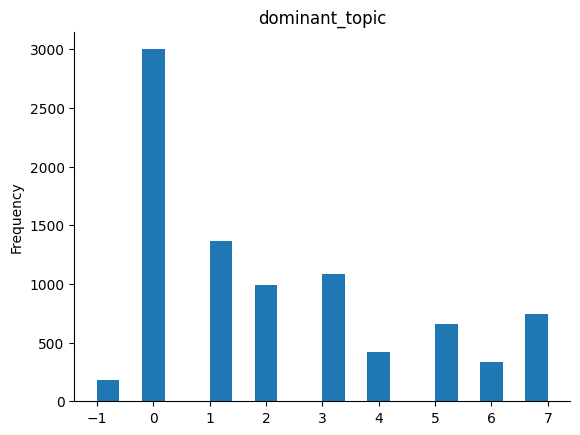

In [13]:
df_political['dominant_topic'].plot(kind='hist', bins=20, title='dominant_topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
def analyze_sentiment(df_political):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_data = []

    for text in df_political['content']:
        try:
            scores = analyzer.polarity_scores(str(text))
            sentiment_data.append(scores)
        except:
            sentiment_data.append({'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0})

    #Add sentiment col
    for key in ['compound', 'pos', 'neg', 'neu']:
        df_political[f'sentiment_{key}'] = [s[key] for s in sentiment_data]

    #Categorize sentiment
    df_political['sentiment_category'] = df_political['sentiment_compound'].apply(
        lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral'
    )
    print("Sentiment distribution:")
    print(df_political['sentiment_category'].value_counts())
    return df_political




df_political = analyze_sentiment(df_political)


Sentiment distribution:
sentiment_category
positive    4549
negative    3970
neutral      262
Name: count, dtype: int64


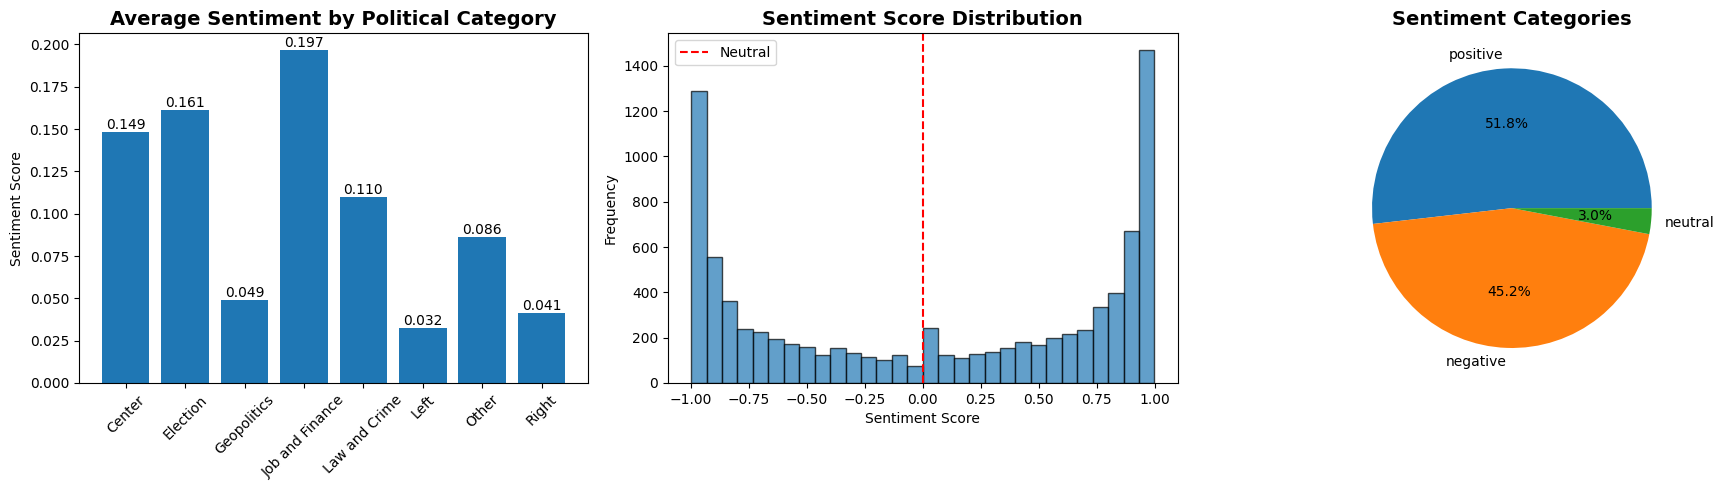

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Sentiment by political cat / bar chart
ax = axes[0]
sentiment_means = df_political.groupby('political_cat')['sentiment_compound'].mean()
bars = ax.bar(sentiment_means.index, sentiment_means.values)
ax.set_title('Average Sentiment by Political Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Sentiment Score')
ax.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
            ha='center', va='bottom')

# 2. Sentiment dist / bar chart
ax = axes[1]
ax.hist(df_political['sentiment_compound'], bins=30, alpha=0.7, edgecolor='black')
ax.set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
ax.axvline(0, color='red', linestyle='--', label='Neutral')
ax.legend()

# 3. Sentiment cat / pie chart
ax = axes[2]
sentiment_counts = df_political['sentiment_category'].value_counts()
ax.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
ax.set_title('Sentiment Categories', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [17]:
class DiscourseAnalyzer:
    def __init__(self):
        self.keywords = [
    #1. EVIDENCE & EMPIRICAL GROUNDING (25 keywords)
    # Indicators that speakers ground claims in external evidence
    'evidence', 'proof', 'data', 'statistics', 'facts', 'findings', 'results',
    'study', 'studies', 'research', 'survey', 'poll', 'analysis', 'report',
    'documentation', 'according', 'shows', 'indicates', 'demonstrates', 'reveals',
    'confirms', 'suggests', 'found', 'concluded', 'published',



    #2. LOGICAL STRUCTURE & REASONING (32 keywords)
    #Markers of structured argumentation and logical flow
    #Causal reasoning
    'therefore', 'thus', 'consequently', 'hence', 'because', 'since', 'due',
    'causes', 'leads', 'results', 'affects', 'influences',

    #Contrast & comparison
    'however', 'although', 'nevertheless', 'whereas', 'while', 'instead',
    'alternatively', 'conversely', 'despite', 'yet', 'but',

    #Addition & emphasis
    'furthermore', 'moreover', 'additionally', 'also', 'similarly', 'likewise',
    'indeed', 'specifically', 'particularly',



    #3. ANALYTICAL & CRITICAL THINKING (28 keywords)
    #Terms indicating evaluation, assessment, and systematic analysis

    #Evaluation terms
    'analyze', 'evaluate', 'assess', 'examine', 'consider', 'review',
    'investigate', 'explore', 'determine', 'measure',

    #Comparison & judgment
    'compare', 'contrast', 'weigh', 'balance', 'judge', 'critique', 'question',
    'challenge', 'scrutinize', 'validate',

    #Complexity recognition
    'complex', 'complicated', 'nuanced', 'multifaceted', 'intricate',
    'sophisticated', 'comprehensive', 'systematic',



    #4. POLICY & GOVERNANCE FOCUS (35 keywords)
    #Concrete policy-oriented language and governance concepts
    #Policy process
    'policy', 'legislation', 'law', 'regulation', 'reform', 'proposal',
    'initiative', 'program', 'implementation', 'enforcement',

    #Governance & institutions
    'government', 'administration', 'congress', 'senate', 'court', 'constitution',
    'democracy', 'democratic', 'institutional', 'bureaucracy',

    #Policy areas
    'economic', 'fiscal', 'social', 'environmental', 'healthcare', 'education',
    'defense', 'foreign', 'domestic', 'budget', 'taxation', 'welfare',
    'infrastructure', 'climate', 'security',



    #5. DELIBERATIVE QUALITY & NUANCE (24 keywords)
    #Markers of thoughtful, qualified discourse that acknowledges complexity

    #Epistemic humility
    'perhaps', 'possibly', 'likely', 'probably', 'might', 'could', 'may',
    'seems', 'appears', 'tends', 'suggests', 'potentially',

    #Qualification & nuance
    'partly', 'somewhat', 'relatively', 'generally', 'typically', 'usually',
    'often', 'sometimes', 'arguably', 'presumably', 'moderately', 'partially',

    #6. STAKEHOLDER & PERSPECTIVE AWARENESS (20 keywords)
    #Recognition of multiple viewpoints and affected parties
    #Perspective markers
    'perspective', 'viewpoint', 'opinion', 'position', 'stance', 'argument',
    'claim', 'belief', 'concern', 'interest',

    #Stakeholder recognition
    'citizens', 'voters', 'taxpayers', 'community', 'public', 'society',
    'groups', 'parties', 'stakeholders', 'constituencies',



    #7. TEMPORAL & CONTEXTUAL AWARENESS (18 keywords)
    #Historical consciousness and contextual understanding

    #Historical context
    'history', 'historical', 'previously', 'traditionally', 'originally',
    'established', 'precedent', 'legacy', 'past',

    #Contemporary context
    'current', 'recent', 'modern', 'contemporary', 'today', 'now', 'present',
    'future', 'trends',

    #8. CONSTRUCTIVE ENGAGEMENT (15 keywords)
    # Markers of collaborative and constructive discourse

    #Collaborative language
    'together', 'cooperation', 'collaboration', 'consensus', 'compromise',
    'dialogue', 'discussion', 'debate', 'negotiate',

    #Solution orientation
    'solution', 'resolve', 'address', 'improve', 'fix', 'reform'
        ]

    def calculate_metrics(self, text):
        #we use original content for metric, not cleaned content
        if not isinstance(text, str) or not text.strip():
            return {
                'content_length': 0, 'word_count': 0, 'sentence_count': 1,
                'keyword_count': 0, 'keyword_density': 0.0, 'has_links': False
            }

        content_length = len(text)
        words = text.split()
        word_count = len(words)


        sentence_count = max(1, len([s for s in re.split(r'[.!?]+', text) if s.strip()]))

        text_lower = text.lower()
        keyword_count = sum(1 for keyword in self.keywords if keyword in text_lower)
        keyword_density = keyword_count / max(1, word_count)

        # Check for links
        has_links = bool(re.search(r'http[s]?://\S+', text))

        return {
            'content_length': content_length,
            'word_count': word_count,
            'sentence_count': sentence_count,
            'keyword_count': keyword_count,
            'keyword_density': keyword_density,
            'has_links': has_links
        }

def analyze_discourse_vocab(df_political):
    analyzer = DiscourseAnalyzer()
    print("Analyzing usage of discourse vocabulary....")

    #Calculate metric for each text
    metrics_list = []
    for text in df_political['content']:  # Use original content, not cleaned
        metrics = analyzer.calculate_metrics(text)
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list)
    for col in metrics_df.columns:
        df_political[col] = metrics_df[col].values

    null_counts = df_political[metrics_df.columns].isnull().sum()
    print(f"Null values check: {null_counts.sum()} total nulls")

    print("vocab metrics summary:")
    print(df_political[['content_length', 'word_count', 'keyword_count', 'keyword_density']].describe())

    return df_political

df_political = analyze_discourse_vocab(df_political)


Analyzing usage of discourse vocabulary...
Null values check: 0 total nulls
vocab metrics summary:
       content_length  word_count  keyword_count  keyword_density
count       8781.0000   8781.0000      8781.0000        8781.0000
mean        1262.9220    217.4840         7.5679           0.0400
std         1177.9838    201.7949         6.0436           0.0247
min            9.0000      2.0000         0.0000           0.0000
25%          502.0000     87.0000         3.0000           0.0256
50%          909.0000    157.0000         6.0000           0.0363
75%         1607.0000    278.0000        10.0000           0.0497
max         9758.0000   1720.0000        48.0000           0.7500


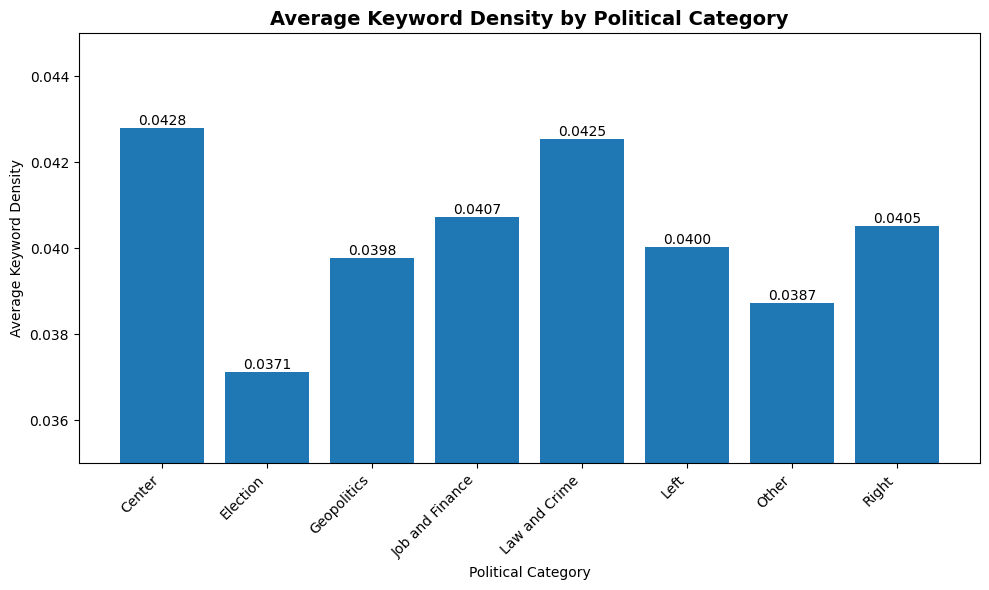

In [39]:
keyword_density_by_category = df_political.groupby('political_cat')['keyword_density'].mean()
plt.figure(figsize=(10, 6))
bars = plt.bar(keyword_density_by_category.index, keyword_density_by_category.values)
plt.title('Average Keyword Density by Political Category', fontsize=14, fontweight='bold')
plt.xlabel('Political Category')
plt.ylabel('Average Keyword Density')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

# Scale the y-axis for better comparison
plt.ylim(0.035, 0.045) # Adjust limits based on the data range

plt.show()

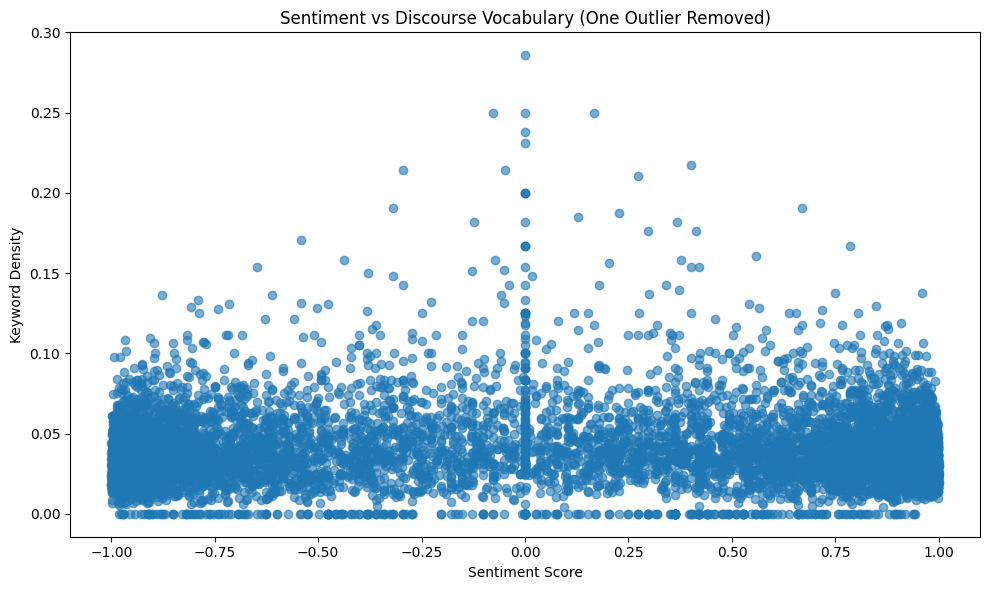

In [32]:
# 2.Sentiment vs keyword (removed one entry w/ over density > 0.7 as outlier)
df_filtered_scatter = df_political[df_political['keyword_density'] <= 0.7].copy()
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_filtered_scatter['sentiment_compound'], df_filtered_scatter['keyword_density'], alpha=0.6)
ax.set_title('Sentiment vs Discourse Vocabulary (One Outlier Removed)')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Keyword Density')

plt.tight_layout()
plt.show()

In [33]:
def statistical_analysis(df_political):
    print("STATISTICAL ANALYSIS")
    print("=" * 50)

    # 1. Sentiment by political category
    print("\n1. SENTIMENT BY POLITICAL CATEGORY")
    sentiment_stats = df_political.groupby('political_cat')['sentiment_compound'].agg([
        'count', 'mean', 'std', 'median'
    ]).round(4)
    print(sentiment_stats)

    # ANOVA test
    groups = [group['sentiment_compound'].values
             for name, group in df_political.groupby('political_cat')]

    if len(groups) > 1:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"\nANOVA: F={f_stat:.4f}, p={p_value:.4f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

    #2. Correlation analysis
    print("\n2. CORRELATION ANALYSIS")
    corr_cols = ['sentiment_compound', 'content_length', 'word_count', 'keyword_count', 'keyword_density']

    #Clean data for correlation
    corr_data = df_political[corr_cols].dropna()
    print(f"Clean data for correlation: {len(corr_data):,} rows")

    if len(corr_data) > 100:
        corr_matrix = corr_data.corr()
        print("\nCorrelation matrix:")
        print(corr_matrix.round(4))

        #Key correlations with significance
        key_pairs = [
            ('sentiment_compound', 'content_length'),
            ('sentiment_compound', 'keyword_density'),
            ('content_length', 'keyword_count')
        ]

        print("\nSignificant correlations:")
        for col1, col2 in key_pairs:
            r, p = stats.pearsonr(corr_data[col1], corr_data[col2])
            sig = "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"  {col1} vs {col2}: r={r:.4f}, p={p:.4f}{sig}")
    else:
        print("Insufficient data for reliable correlation analysis")

    # 3. Discourse vocab by political cat
    print("\n3. DISCOURSE VOCABULARY BY CATEGORY")
    vocab_stats = df_political.groupby('political_cat')[
        ['content_length', 'word_count', 'keyword_count', 'keyword_density']
    ].mean().round(4)
    print(vocab_stats)

    return df_political

df_political = statistical_analysis(df_political)


STATISTICAL ANALYSIS

1. SENTIMENT BY POLITICAL CATEGORY
                 count   mean    std  median
political_cat                               
Center             107 0.1485 0.8368  0.6705
Election           107 0.1610 0.7178  0.3911
Geopolitics        469 0.0488 0.7791  0.1531
Job and Finance    454 0.1968 0.7293  0.4012
Law and Crime      107 0.1099 0.7879  0.2656
Left              5862 0.0322 0.7648  0.0772
Other              714 0.0864 0.7802  0.2483
Right              961 0.0411 0.7912  0.1725

ANOVA: F=3.7196, p=0.0005
Significant difference: Yes

2. CORRELATION ANALYSIS
Clean data for correlation: 8,781 rows

Correlation matrix:
                    sentiment_compound  content_length  word_count  \
sentiment_compound              1.0000          0.0419      0.0369   
content_length                  0.0419          1.0000      0.9968   
word_count                      0.0369          0.9968      1.0000   
keyword_count                   0.0718          0.8590      0.8450   
key

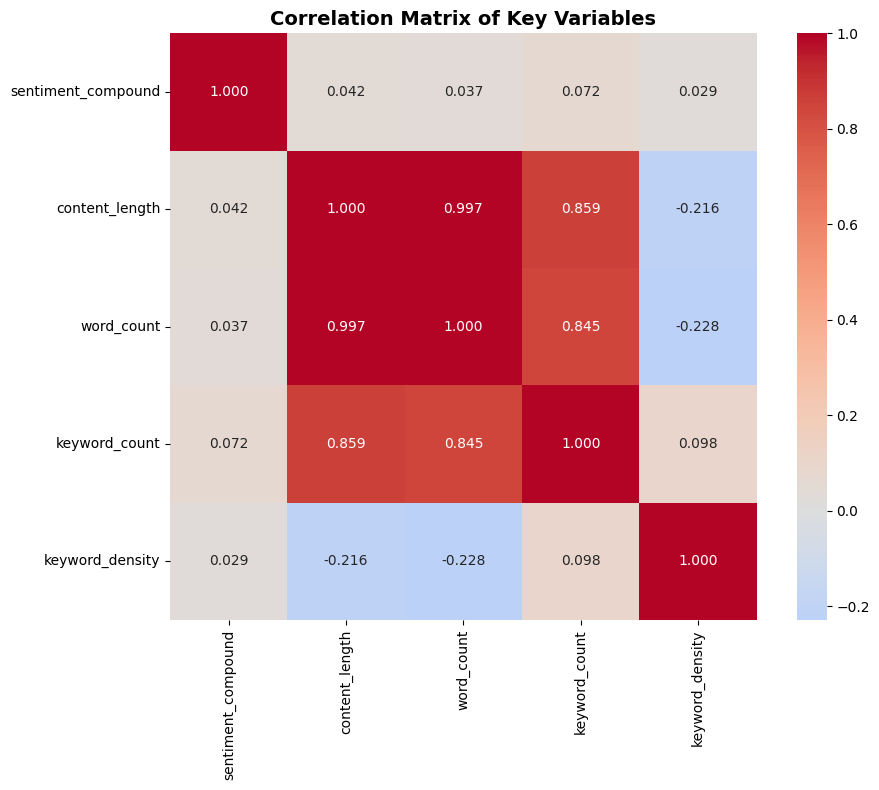

In [34]:
# Correlation analysis visualization
plt.figure(figsize=(10, 8))
corr_cols = ['sentiment_compound', 'content_length', 'word_count', 'keyword_count', 'keyword_density']
corr_data = df_political[corr_cols].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, fmt='.3f', square=True)
plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

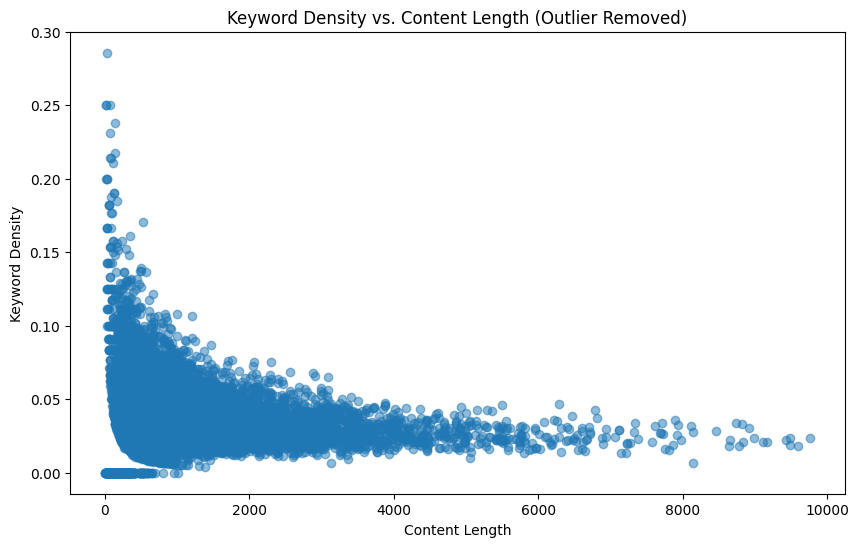

In [ ]:
df_filtered = df_political[df_political['keyword_density'] <= 0.7].copy()

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['content_length'], df_filtered['keyword_density'], alpha=0.5)
plt.title('Keyword Density vs. Content Length (Outlier Removed)')
plt.xlabel('Content Length')
plt.ylabel('Keyword Density')
plt.show()

In [35]:
def generate_report(df_political, topics):
    print("DISCOURSE VOCABULARY ANALYSIS REPORT")
    print("=" * 50)

    print(f"\nDataset Summary:")
    print(f"Total political comments: {len(df_political):,}")
    print(f"Political categories: {df_political['political_cat'].nunique()}")

    print(f"\nSample Distribution:")
    for cat, count in df_political['political_cat'].value_counts().items():
        pct = (count / len(df_political)) * 100
        print(f"  {cat}: {count:,} ({pct:.1f}%)")

    print(f"\nSentiment Analysis:")
    sentiment_stats = df_political.groupby('political_cat')['sentiment_compound'].agg(['mean', 'std'])
    for cat in sentiment_stats.index:
        mean_val = sentiment_stats.loc[cat, 'mean']
        std_val = sentiment_stats.loc[cat, 'std']
        print(f"  {cat}: {mean_val:.4f} ± {std_val:.4f}")

    # ANOVA result
    groups = [group['sentiment_compound'].values for name, group in df_political.groupby('political_cat')]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nStatistical Test (ANOVA):")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Result: {'Significant difference' if p_value < 0.05 else 'No significant difference'} between groups")

    print(f"\nDiscourse Vocabulary Usage:")
    vocab_means = df_political.groupby('political_cat')[['content_length', 'keyword_density']].mean()
    for cat in vocab_means.index:
        length = vocab_means.loc[cat, 'content_length']
        density = vocab_means.loc[cat, 'keyword_density']
        print(f"  {cat}: avg length={length:.0f}, keyword density={density:.4f}")

    if topics:
        print(f"\nTopic Analysis:")
        print(f"Number of topics identified: {len(topics)}")
        for topic_name, words in topics.items():
            print(f"  {topic_name}: {', '.join(words[:5])}")

    # Data quality check
    print(f"\nData Quality:")
    null_counts = df_political[['sentiment_compound', 'content_length', 'keyword_density']].isnull().sum()
    print(f"  Null values: {null_counts.sum()} total")
    print(f"  Complete cases: {len(df_political) - null_counts.max():,}")

    print(f"\nKey Findings:")
    if p_value < 0.05:
        print(f"  - Statistically significant differences in sentiment across political categories")
    else:
        print(f"  - No statistically significant sentiment differences between political groups")

    corr_sentiment_Diskeywords = df_political['sentiment_compound'].corr(df_political['keyword_density'])
    print(f"  - Sentiment & Discourse Vocab density correlation: {corr_sentiment_Diskeywords:.4f}")

    print(f"\nLimitations:")
    print(f"  - Political classification based on subreddit affiliation")
    print(f"  - Sentiment analysis may not capture political context")
    print(f"  - Cross-sectional analysis without temporal dynamics")

generate_report(df_political, topics)

try:
    df_political.to_csv('political_discourse_analysis.csv', index=False)
    print(f"\nResults saved to 'political_discourse_analysis.csv'")
except Exception as e:
    print(f"Error saving: {e}")


DISCOURSE VOCABULARY ANALYSIS REPORT

Dataset Summary:
Total political comments: 8,781
Political categories: 8

Sample Distribution:
  Left: 5,862 (66.8%)
  Right: 961 (10.9%)
  Other: 714 (8.1%)
  Geopolitics: 469 (5.3%)
  Job and Finance: 454 (5.2%)
  Law and Crime: 107 (1.2%)
  Center: 107 (1.2%)
  Election: 107 (1.2%)

Sentiment Analysis:
  Center: 0.1485 ± 0.8368
  Election: 0.1610 ± 0.7178
  Geopolitics: 0.0488 ± 0.7791
  Job and Finance: 0.1968 ± 0.7293
  Law and Crime: 0.1099 ± 0.7879
  Left: 0.0322 ± 0.7648
  Other: 0.0864 ± 0.7802
  Right: 0.0411 ± 0.7912

Statistical Test (ANOVA):
  F-statistic: 3.7196
  P-value: 0.0005
  Result: Significant difference between groups

Discourse Vocabulary Usage:
  Center: avg length=1683, keyword density=0.0428
  Election: avg length=1014, keyword density=0.0371
  Geopolitics: avg length=1281, keyword density=0.0398
  Job and Finance: avg length=1317, keyword density=0.0407
  Law and Crime: avg length=1482, keyword density=0.0425
  Left: avg